In [2]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil

import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetaForObjectDetection
from transformers import DetaConfig, DetaImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [3]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', processor=processor, image_name="coco_train_max.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', processor=processor, image_name="coco_val_max.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))



loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [4]:
class Deta(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetaForObjectDetection.from_pretrained("jozhang97/deta-resnet-50",
                                                             num_labels=len(id2label),
                                                             auxiliary_loss=True,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [5]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETA",
            "dataset": "All_Data",
            "train_set_size": len(train_dataset)}
    )

model = Deta(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 1700

wandb_logger = WandbLogger("DETA", "../models/", project=project, log_model=True, checkpoint_name=f"DETA_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1700` reached.


# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_300_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")

In [6]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_1700_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")

wandb: Downloading large artifact DETA_1700_Steps:v0, 551.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embe

In [7]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Deta(
  (model): DetaForObjectDetection(
    (model): DetaModel(
      (backbone): DetaBackboneWithPositionalEncodings(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetaFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetaFrozenBatchNorm2d()
                    )
                    (layer):

In [9]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/215 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.2055, 0.2029, 0.2025, 0.2006, 0.1984, 0.1967, 0.1943, 0.1914, 0.1884,
        0.1866, 0.1841, 0.1829, 0.1813, 0.1802, 0.1755, 0.1739, 0.1704, 0.1663,
        0.1644, 0.1642, 0.1607, 0.1568, 0.1560, 0.1556, 0.1497, 0.1479, 0.1342,
        0.1314, 0.1251, 0.1185, 0.1178, 0.1168, 0.1133, 0.1117, 0.1117, 0.1110,
        0.1086, 0.1062, 0.1000], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 4, 3, 9], device='cuda:0'), 'boxes': tensor([[1242.4701,  434.0698, 1267.1910,  547.4771],
        [ 460.0943,  556.7152,  473.3523,  573.5223],
        [ 458.3096,  555.0784,  472.8896,  576.8013],
        [ 357.3998,  848.8779,  371.7593,  868.4269],
        [ 456.4944,  554.3005,  475.6806,  585.4152],
        [ 983.5691,  785.2728,  996.1393,  801.6636],
        [ 356.6958,  847.7770,  373.9797,  873.6487],
        [ 980.9919,  784.2483,  995.9171,  806.6998],
        [1162.8

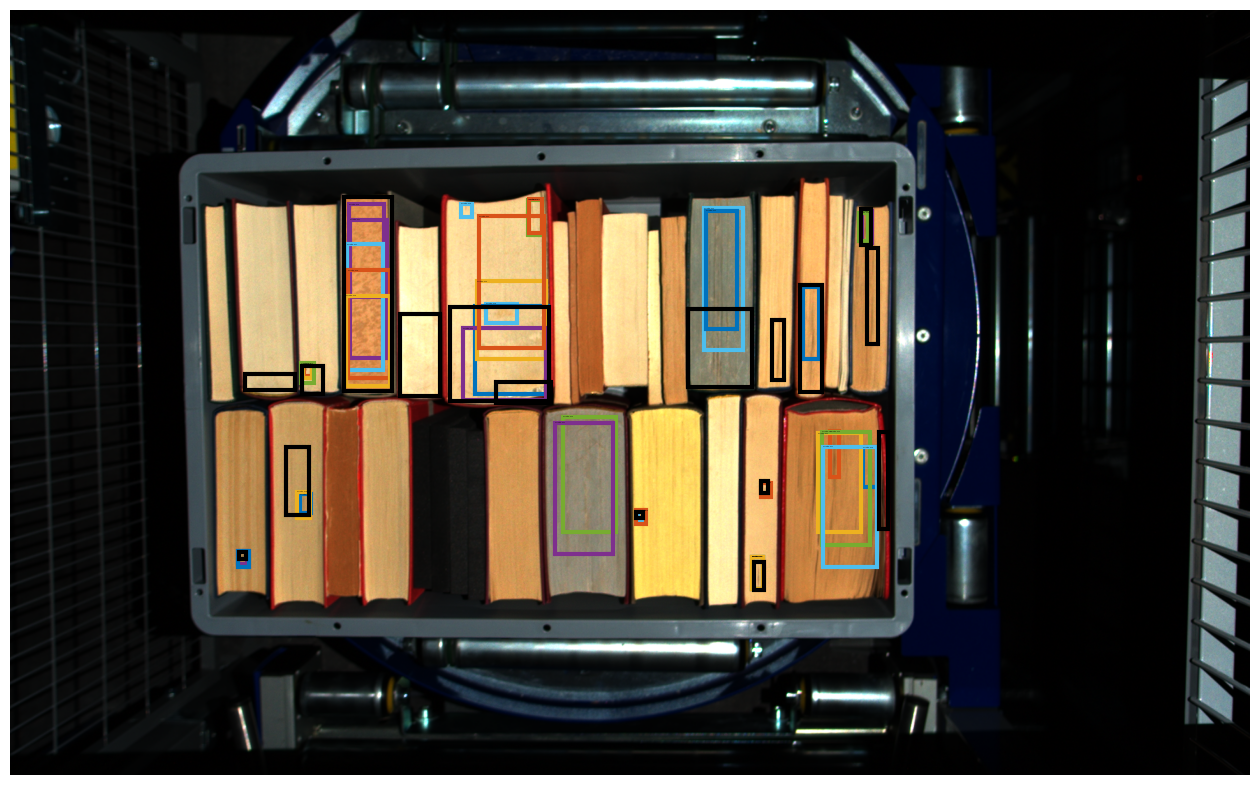

{'scores': tensor([0.2448, 0.2253, 0.2197, 0.2179, 0.2178, 0.2166, 0.2163, 0.2143, 0.2139,
        0.2137, 0.2117, 0.2051, 0.2034, 0.1985, 0.1851, 0.1808, 0.1757, 0.1742,
        0.1740, 0.1736, 0.1703, 0.1679, 0.1654, 0.1642, 0.1627, 0.1613, 0.1605,
        0.1581, 0.1578, 0.1576, 0.1570, 0.1480, 0.1479, 0.1462, 0.1458, 0.1455,
        0.1455, 0.1448, 0.1380, 0.1280, 0.1248, 0.1244, 0.1214, 0.1188, 0.1182,
        0.1152, 0.1142, 0.1103, 0.1087, 0.1081, 0.1076, 0.1070, 0.1066, 0.1043,
        0.1038, 0.1013, 0.1002], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 9, 6, 3, 3, 4, 6, 6, 3,
        6, 9, 4, 9, 6, 3, 4, 4, 9], device='cuda:0'), 'boxes': tensor([[1281.5471,  649.3170, 1310.1549,  709.7194],
        [ 347.4030,  676.4247,  362.9776,  696.6971],
        [ 344.4294,  674.7892,  365.7828,  700.4371],
        [ 795.5820,  657.0856,  810.7450,  691.5587],
        [

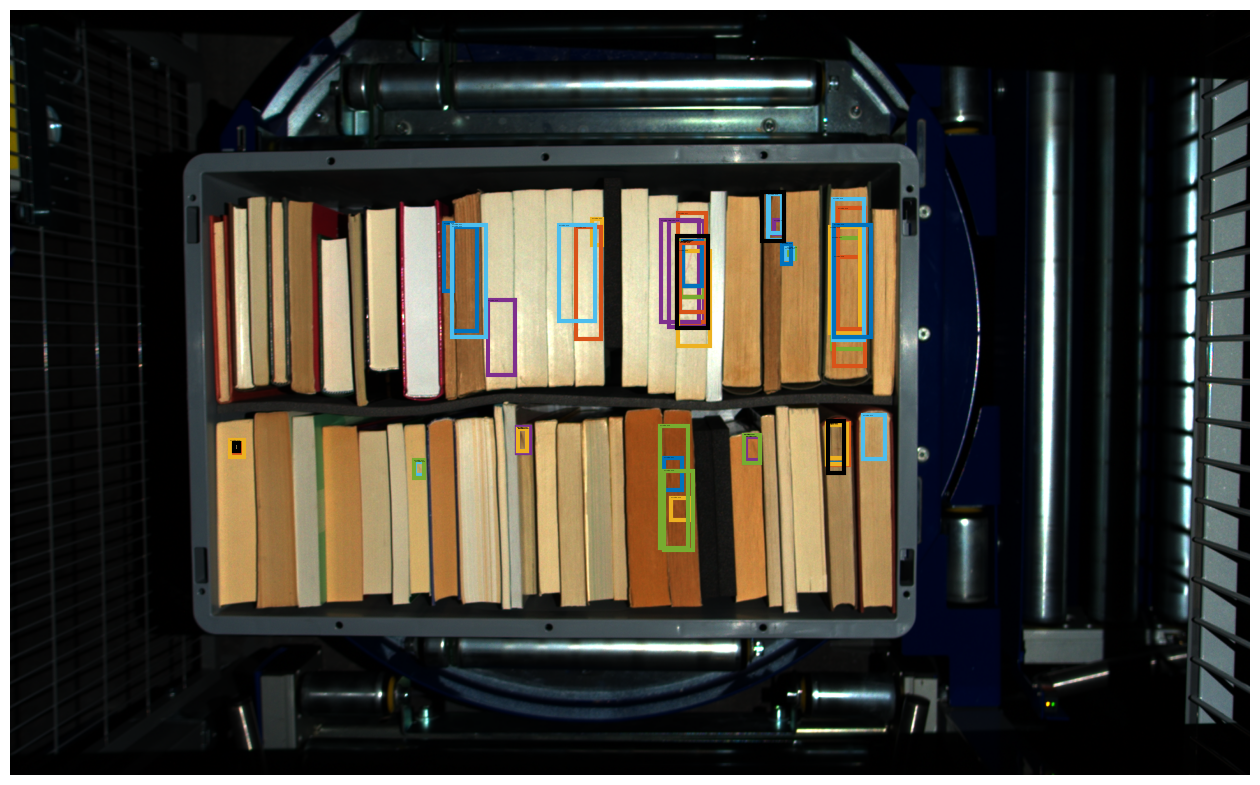

{'scores': tensor([0.3360, 0.3288, 0.3120, 0.2630, 0.2290, 0.2286, 0.2283, 0.2243, 0.2104,
        0.2074, 0.2031, 0.2018, 0.1988, 0.1933, 0.1872, 0.1784, 0.1748, 0.1744,
        0.1722, 0.1679, 0.1679, 0.1639, 0.1562, 0.1529, 0.1515, 0.1464, 0.1427,
        0.1380, 0.1323, 0.1297, 0.1270, 0.1266, 0.1191, 0.1191, 0.1183, 0.1178,
        0.1167, 0.1160, 0.1158, 0.1139, 0.1125, 0.1122, 0.1112, 0.1108, 0.1107,
        0.1106, 0.1098, 0.1097, 0.1093, 0.1091, 0.1086, 0.1086, 0.1080, 0.1067,
        0.1063, 0.1048, 0.1041, 0.1040, 0.1033, 0.1024, 0.1022, 0.1019, 0.1018],
       device='cuda:0'), 'labels': tensor([6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 6, 6, 6,
        3, 6, 3, 6, 3, 3, 3, 3, 9, 6, 3, 3, 4, 4, 9, 9, 3, 3, 3, 4, 4, 9, 3, 3,
        3, 9, 3, 3, 3, 3, 3, 3, 6, 9, 9, 6, 4, 4, 9], device='cuda:0'), 'boxes': tensor([[ 926.6367,  614.9609,  956.1248,  647.0048],
        [ 924.4296,  612.9560,  959.0319,  656.5858],
        [ 917.8900,  615.6368,  952.1335,  6

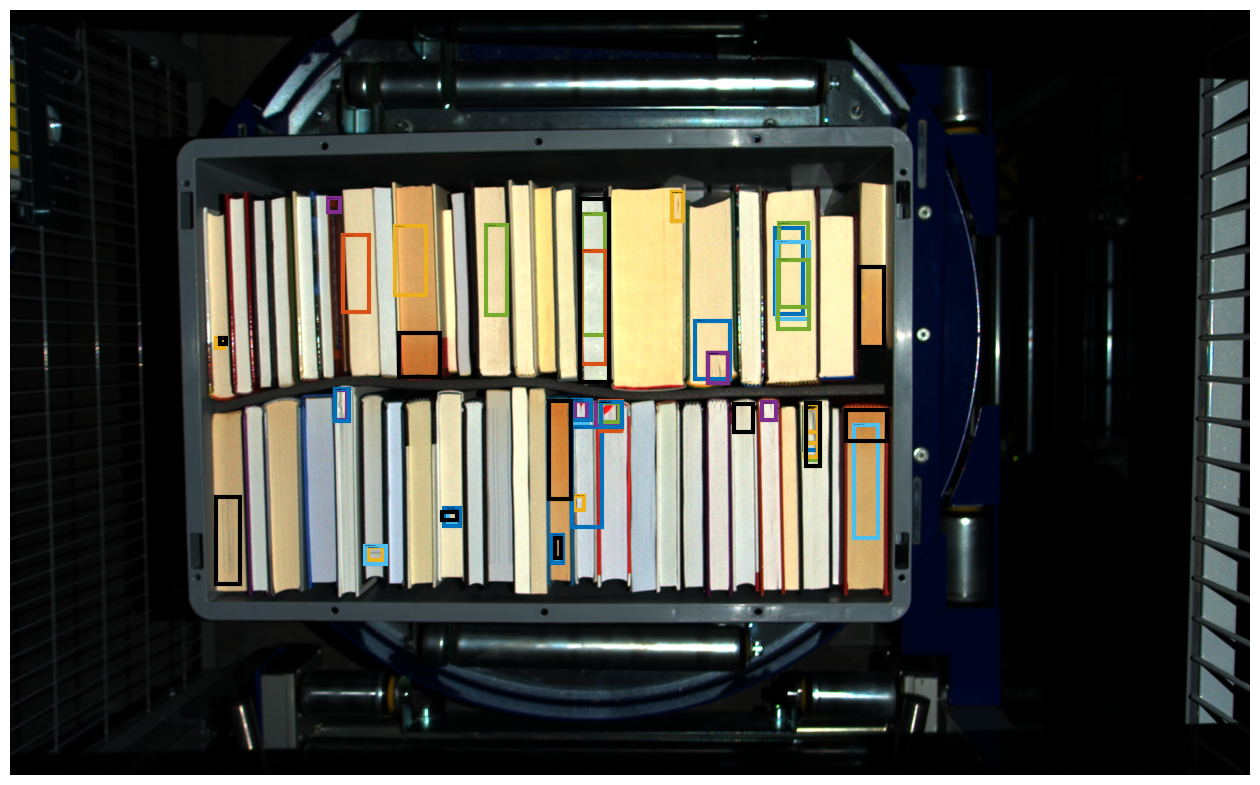

{'scores': tensor([0.2335, 0.2274, 0.2244, 0.2121, 0.2063, 0.2034, 0.2025, 0.1984, 0.1969,
        0.1966, 0.1959, 0.1956, 0.1864, 0.1842, 0.1834, 0.1798, 0.1769, 0.1768,
        0.1741, 0.1692, 0.1682, 0.1652, 0.1639, 0.1618, 0.1598, 0.1587, 0.1556,
        0.1555, 0.1496, 0.1490, 0.1484, 0.1468, 0.1465, 0.1462, 0.1442, 0.1436,
        0.1402, 0.1306, 0.1283, 0.1261, 0.1254, 0.1236, 0.1189, 0.1135, 0.1118,
        0.1112, 0.1111, 0.1109, 0.1042, 0.1035, 0.1002], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3,
        3, 3, 6], device='cuda:0'), 'boxes': tensor([[ 402.1180,  379.4081,  428.6115,  415.7489],
        [ 401.9778,  469.8543,  419.8214,  486.4926],
        [ 399.2500,  467.7756,  421.0171,  490.6910],
        [ 394.5533,  466.5575,  426.0318,  529.2421],
        [ 391.8004,  289.5799,  425.1837,  407.3575],
        [ 455.2172,  391.8412

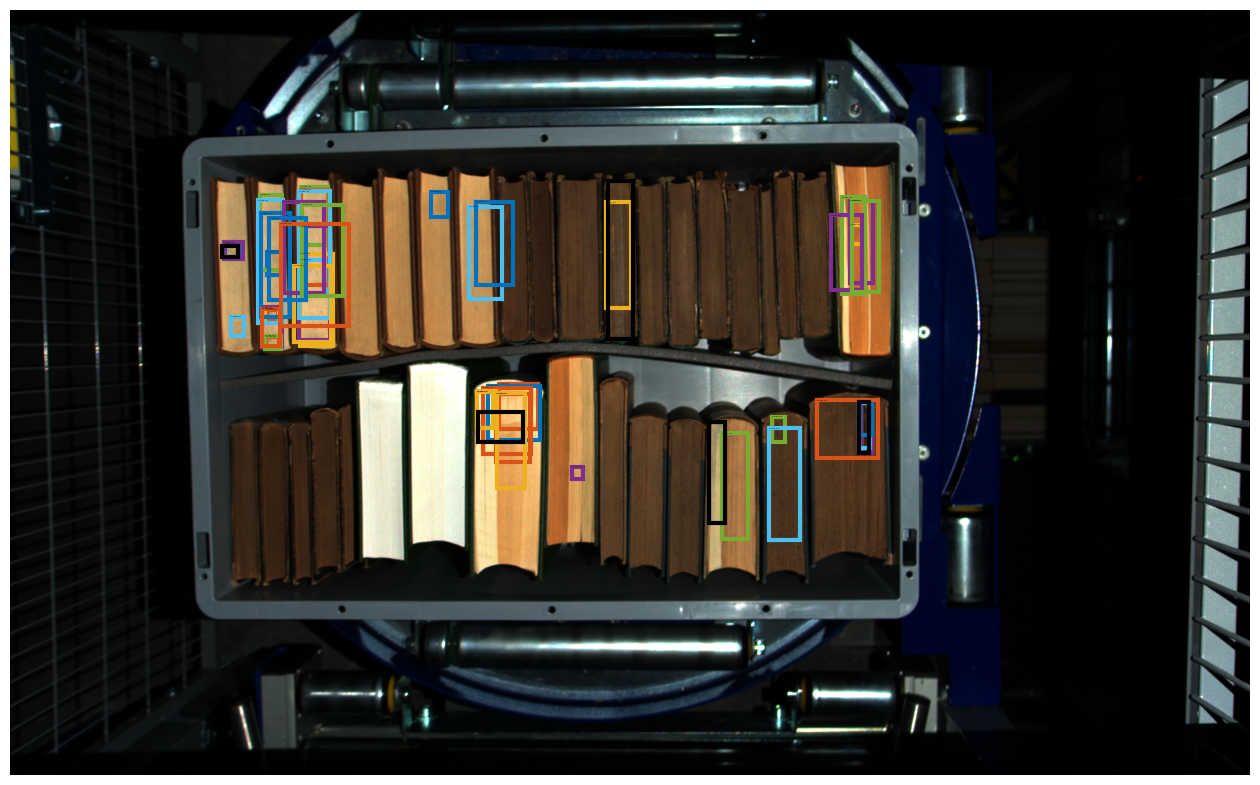

{'scores': tensor([0.2203, 0.2153, 0.2133, 0.2114, 0.2101, 0.2040, 0.2002, 0.1944, 0.1942,
        0.1935, 0.1895, 0.1821, 0.1780, 0.1779, 0.1747, 0.1731, 0.1728, 0.1706,
        0.1576, 0.1423, 0.1385, 0.1359, 0.1336, 0.1330, 0.1297, 0.1286, 0.1280,
        0.1255, 0.1247, 0.1220, 0.1219, 0.1183, 0.1180, 0.1146, 0.1144, 0.1120,
        0.1077, 0.1032, 0.1022, 0.1005], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 3, 3, 3, 3, 6, 3], device='cuda:0'), 'boxes': tensor([[1285.5558,  596.1403, 1320.2942,  670.3132],
        [1284.6552,  598.0080, 1314.7115,  660.7686],
        [1038.8413,  602.0302, 1060.1105,  644.5646],
        [1035.6868,  600.5869, 1064.2041,  648.0424],
        [1283.6993,  601.4952, 1307.7981,  668.9809],
        [ 467.1317,  535.0494,  480.1465,  552.5133],
        [1284.8623,  601.9530, 1301.6779,  656.9151],
        [ 468.3060,  533.4259,  483.0244,  554.2764],
    

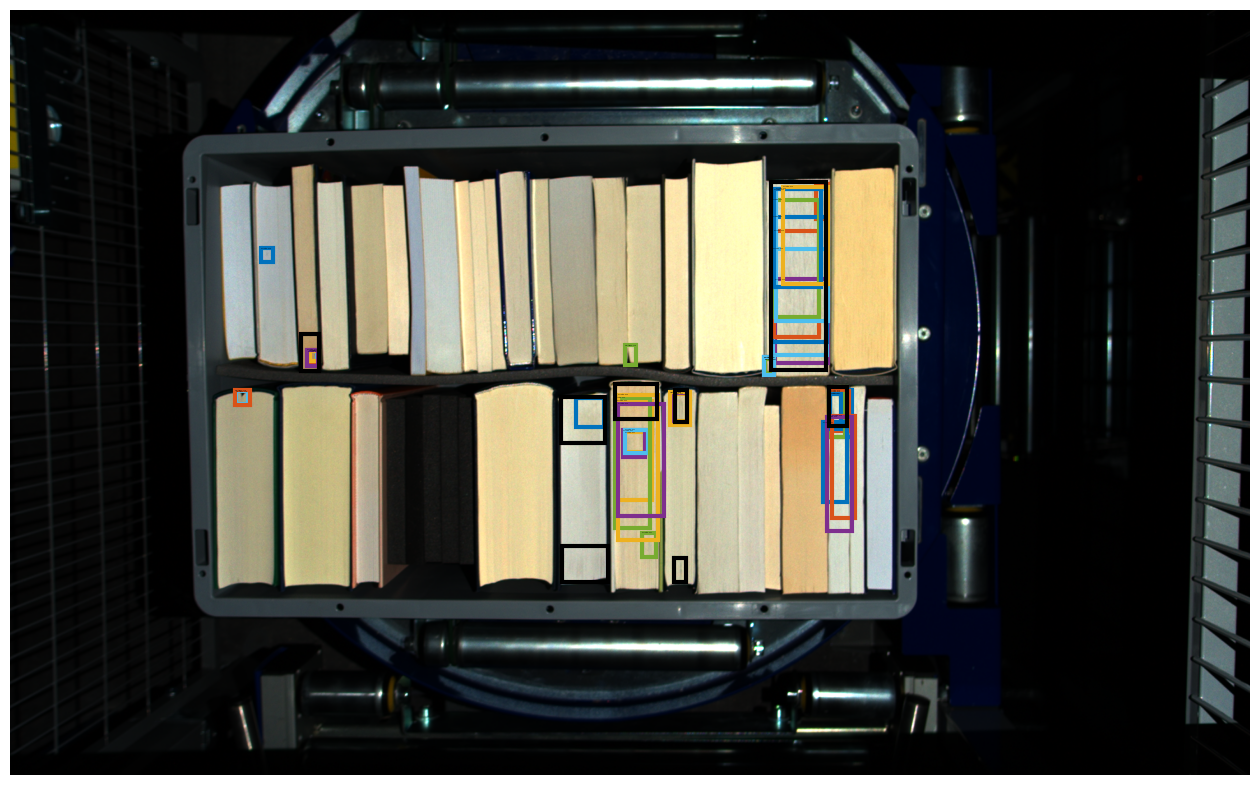

{'scores': tensor([0.1866, 0.1831, 0.1762, 0.1758, 0.1752, 0.1735, 0.1727, 0.1725, 0.1670,
        0.1626, 0.1623, 0.1618, 0.1607, 0.1605, 0.1604, 0.1575, 0.1554, 0.1544,
        0.1544, 0.1535, 0.1534, 0.1529, 0.1511, 0.1458, 0.1414, 0.1407, 0.1404,
        0.1374, 0.1356, 0.1340, 0.1329, 0.1315, 0.1293, 0.1274, 0.1255, 0.1243,
        0.1239, 0.1212, 0.1206, 0.1175, 0.1150, 0.1139, 0.1128, 0.1106, 0.1105,
        0.1105, 0.1098, 0.1087, 0.1085, 0.1077, 0.1059, 0.1052, 0.1044, 0.1019,
        0.1010, 0.1010], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1051.6384,  333.7736, 1103.8165,  359.3936],
        [ 607.8350,  703.4387,  680.9969,  728.5889],
        [ 602.8716,  701.4060,  682.4181,  734.9437],
        [ 405.0620,  789.3976,  419.8083,  806.4354],
        [ 885.1648, 

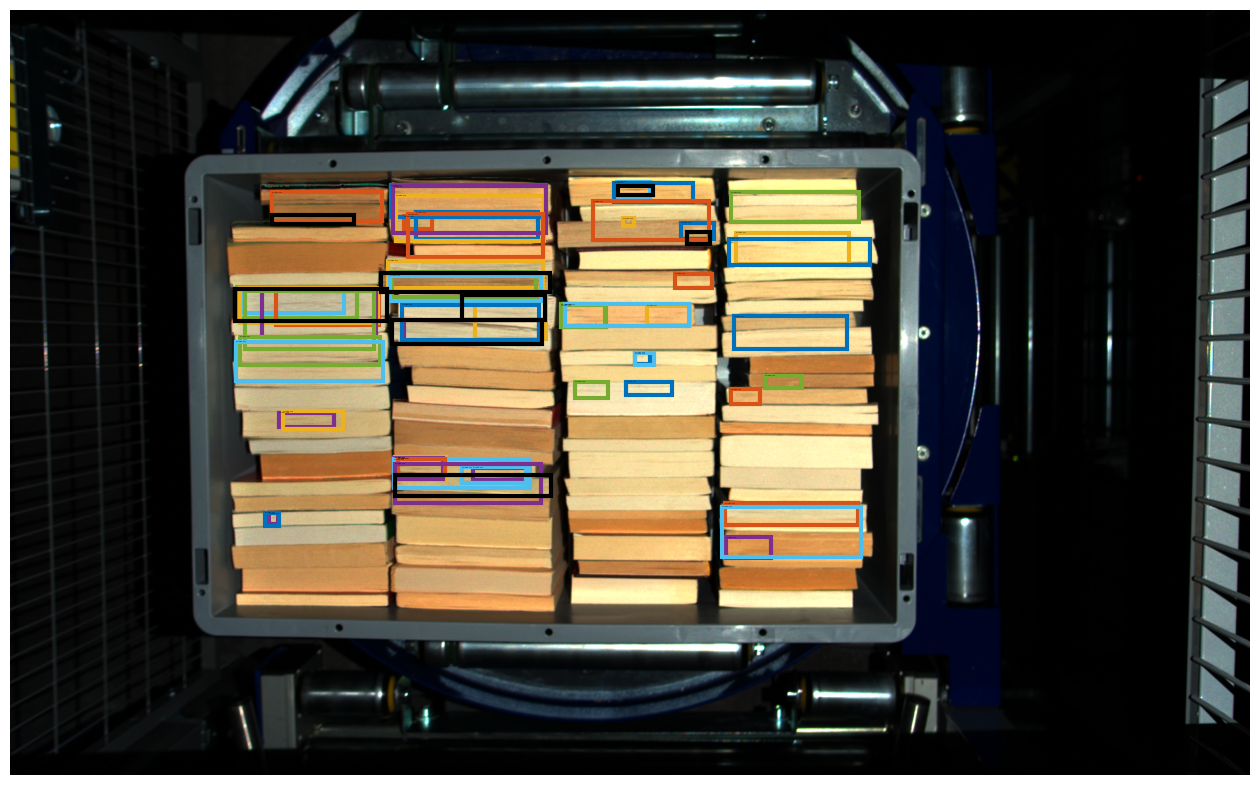

In [11]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.1)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)